In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import IBMQ
from qiskit import execute
from qiskit import Aer

from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, complete_meas_cal
from qiskit.visualization import plot_histogram

In [1]:
IBMQ.load_account()

In [4]:
from qiskit.aqua.algorithms import DeutschJozsa
from qiskit.aqua.components.oracles import TruthTableOracle

# Deutsch-Jozsa algorithm

We want to implement the Deutsch-Jozsa algorithm to check if a two-bit function is balanced or constant. 
The two-bit function is specified by the following truth table
 
 | input 1 | input 2 | output |
 |---|---|---|
 | 0 | 0 | **0** |
 | 0 | 1 | **0** | 
 | 1 | 0 | **1** | 
 | 1 | 1 | **1** |
 
To specify the truth table, it is sufficient to indicate the **output** row:

In [5]:
# create a two-bit oracle
oracle_2bit = TruthTableOracle('0011')

The TruthTableOracle object calculates the required quantum circuit to implement this truth table for us. Let's have a look at it:

In [6]:
# inspect the circuit of the oracle
oracle_2bit.circuit.draw()

┌───┐     ┌───┐
v_0: ──■──┤ X ├──■──┤ X ├
       │  └───┘  │  └───┘
v_1: ──■─────────■───────
     ┌─┴─┐     ┌─┴─┐     
o_0: ┤ X ├─────┤ X ├─────
     └───┘     └───┘

In a first step, we want to check this quantum circuit. 
Therefore, we must apply all four basis states to it and measure the value of the output register. 

In [7]:
def encode_classical_information(x, qr_v, qc):
    if x == 1:
        qc.x(qr_v[0])
    elif x == 2:
        qc.x(qr_v[1])
    elif x == 3:
        qc.x(qr_v[0])
        qc.x(qr_v[1])
    
    qc.barrier()
    return qc

def measure_output(qr_o, cr_o, qc):
    qc.measure(qr_o[0], cr_o[0])
    
    return qc

In [8]:
# define a circuit to check the oracle for one value of x
def full_circuit(x, oracle):
    qr_v = QuantumRegister(2, 'v')
    qr_o = QuantumRegister(1, 'o')
    cr_o = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(qr_v, qr_o, cr_o)
    
    return (  encode_classical_information(x, qr_v, qc) 
            + oracle.circuit 
            + measure_output(qr_o, cr_o, qc))

In [9]:
# circuits for all values of x
qcs = [ full_circuit(x, oracle_2bit) for x in range(4) ]

Have a look at what we defined:

In [10]:
# inspect circuit
qcs[3].draw()

┌───┐ ░      ┌───┐     ┌───┐┌───┐ ░    
v_0: ┤ X ├─░───■──┤ X ├──■──┤ X ├┤ X ├─░────
     ├───┤ ░   │  └───┘  │  ├───┤└───┘ ░    
v_1: ┤ X ├─░───■─────────■──┤ X ├──────░────
     └───┘ ░ ┌─┴─┐     ┌─┴─┐└───┘      ░ ┌─┐
o_0: ──────░─┤ X ├─────┤ X ├───────────░─┤M├
           ░ └───┘     └───┘           ░ └╥┘
c: 1/═════════════════════════════════════╩═
                                          0

Simulate these circuits:

In [11]:
# execute on an ideal quantum computer
job = execute(qcs, Aer.get_backend('qasm_simulator'), shots=8192)

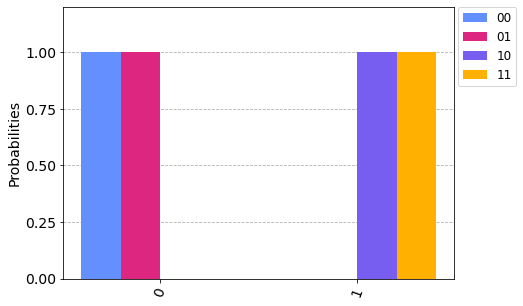

In [12]:
# visualize results
plot_histogram(job.result().get_counts(),
               legend=[str(bin(x))[2:].zfill(2) for x in range(len(qcs))],
               bar_labels=False)

<hr>

Now let's check whether this oracle is balanced or constant:

In [13]:
# initialize a DeutschJozsa object
algo_dj = DeutschJozsa(oracle_2bit, Aer.get_backend('qasm_simulator'))

In [14]:
# Note: the circuit will be cached. Make sure you request the measurement 
# in the very first call of construct_circuit
algo_dj.construct_circuit(measurement=True).draw()

┌───┐      ░      ┌───┐     ┌───┐┌───┐ ░ ┌─┐   
v_0: ┤ H ├──────░───■──┤ X ├──■──┤ X ├┤ H ├─░─┤M├───
     ├───┤      ░   │  └───┘  │  ├───┤└───┘ ░ └╥┘┌─┐
v_1: ┤ H ├──────░───■─────────■──┤ H ├──────░──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐     ┌─┴─┐└───┘      ░  ║ └╥┘
o_0: ┤ X ├┤ H ├─░─┤ X ├─────┤ X ├───────────░──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘           ░  ║  ║ 
m: 2/══════════════════════════════════════════╩══╩═
                                               0  1

In [15]:
# simulate the circuit
out = algo_dj.run(Aer.get_backend('qasm_simulator'))

In [16]:
# get the result
print (out['measurement'])
print (out['result'])

{'10': 1024}
balanced


<hr>